# NicheCompass Oneshot Sample Integration Tutorial

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 18.05.2023
- **Date of Last Modification:** 19.06.2023

In this tutorial, we apply NicheCompass to integrate three samples (sagittal brain sections) of the STARmap PLUS mouse central nervous system dataset / atlas from [Shi, H. et al. Spatial Atlas of the Mouse Central Nervous System at Molecular Resolution. bioRxiv 2022.06.20.496914 (2022)](https://www.biorxiv.org/content/10.1101/2022.06.20.496914v1) in a oneshot setting (i.e. the model is trained on all samples at once).

Sample 1 has:
- 91,246 observations at cellular resolution with cell type annotations
- 1022 probed genes

Sample 2 has:
- 123,836 observations at cellular resolution with cell type annotations
- 1022 probed genes

Sample 3 has:
- 207,591 observations at cellular resolution with cell type annotations
- 1022 probed genes

- Check the repository [README.md](https://github.com/sebastianbirk/nichecompass#installation) for NicheCompass installation instructions.
- The data for this tutorial can be downloaded from [OneDrive](https://1drv.ms/f/s!Atya0VClQocLgvRFj0hYrFICVi0C2w?e=2uLfVX). It has to be stored under ```<repository_root>/data/spatial_omics/```.
  - starmap_plus_mouse_cns_batch1.h5ad
  - starmap_plus_mouse_cns_batch2.h5ad
  - starmap_plus_mouse_cns_batch3.h5ad
- A pretrained model to run only the analysis can be downloaded from [OneDrive](https://1drv.ms/f/s!Atya0VClQocLgvRFj0hYrFICVi0C2w?e=2uLfVX). It has to be stored under ```<repository_root>/artifacts/oneshot_sample_integration/<timestamp>/model/```.
  - xxx

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
from datetime import datetime

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import squidpy as sq
from matplotlib import gridspec

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                aggregate_obsp_matrix_per_cell_type,
                                create_cell_type_chord_plot_from_df,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                generate_enriched_gp_info_plots,
                                get_unique_genes_from_gp_dict)

from color_utils import (latent_cluster_colors,
                         starmap_plus_mouse_cns_cell_type_colors as cell_type_colors)

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/h

### 1.2 Define Parameters

In [3]:
### Dataset ###
dataset = "starmap_plus_mouse_cns"
species = "mouse"
batches = ["batch1", "batch2", "batch3"]
spatial_key = "spatial"
n_neighbors = 12
filter_genes = True
n_hvg = 3000

### Model ###
# AnnData keys
counts_key = "counts"
adj_key = "spatial_connectivities"
condition_key = "batch"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_sources_mask_key = "nichecompass_gp_sources"
latent_key = "nichecompass_latent"

# Architecture
cond_embed_injection = ["encoder", "gene_expr_decoder"]
n_cond_embed = 3
active_gp_thresh_ratio = 0.05
node_label_method = "one-hop-attention" # choose one-hop-norm for significant speed up of model training

# Trainer
n_epochs = 100
n_epochs_all_gps = 25
n_epochs_no_cond_contrastive = 5
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_cond_contrastive = 100000.
contrastive_logits_pos_ratio = 0.06125
contrastive_logits_neg_ratio = 0.
lambda_l1_masked = 0.
edge_batch_size = 1024 # reduce if not enough memory
use_cuda_if_available = True

### Analysis ###
cell_type_key = "Main_molecular_cell_type"
latent_leiden_resolution = 0.2
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "batch"
samples = ["sagittal1", "sagittal2", "sagittal3"]
spot_size = 0.2
agg_weights_key = "agg_weights"
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

### 1.3 Run Notebook Setup

In [4]:
warnings.filterwarnings("ignore")

In [5]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths

In [6]:
# Define paths
ga_data_folder_path = "../data/gene_annotations"
gp_data_folder_path = "../data/gene_programs"
so_data_folder_path = "../data/spatial_omics"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"../artifacts"
model_folder_path = f"{artifacts_folder_path}/oneshot_sample_integration/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/oneshot_sample_integration/{current_timestamp}/figures"

In [7]:
os.makedirs(figure_folder_path, exist_ok=True)

## 2. Model Preparation

### 2.1 Create Prior Knowledge Cell-Cell-Interaction (CCI) Gene Program (GP) Mask

- NicheCompass expects a prior CCI GP mask as input, which it will use to make its latent embedding interpretable (through a linear masked decoder). 
- The user can provide a custom GP mask to NicheCompass based on the dataset, application, and hypothesis of interest.
- As a default, we create a GP mask based on three databases of prior CCI knowledge:
    - OmniPath
    - NicheNet
    - MEBOCOST

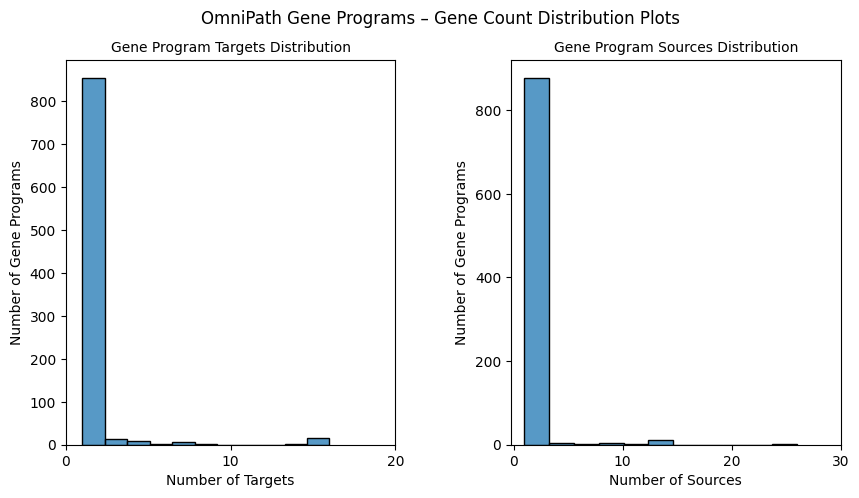

In [8]:
# Retrieve OmniPath GPs (source: ligand gene; target: receptor gene)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species="mouse",
    min_curation_effort=0,
    load_from_disk=True,
    save_to_disk=True,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source and target genes from OmniPath GPs to keep
# those genes when filtering
omnipath_genes = get_unique_genes_from_gp_dict(
    gp_dict=omnipath_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

In [9]:
# Display example OmniPath GPs
for i, (key, value) in enumerate(omnipath_gp_dict.items()):
    if i > 2:
        break
    print(key, value)

BDNF_ligand_receptor_GP {'sources': ['Bdnf'], 'targets': ['Drd4'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}
EPOR_ligand_receptor_GP {'sources': ['Epor'], 'targets': ['Stat3'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}
FYN_ligand_receptor_GP {'sources': ['Fyn'], 'targets': ['Mapk7'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}


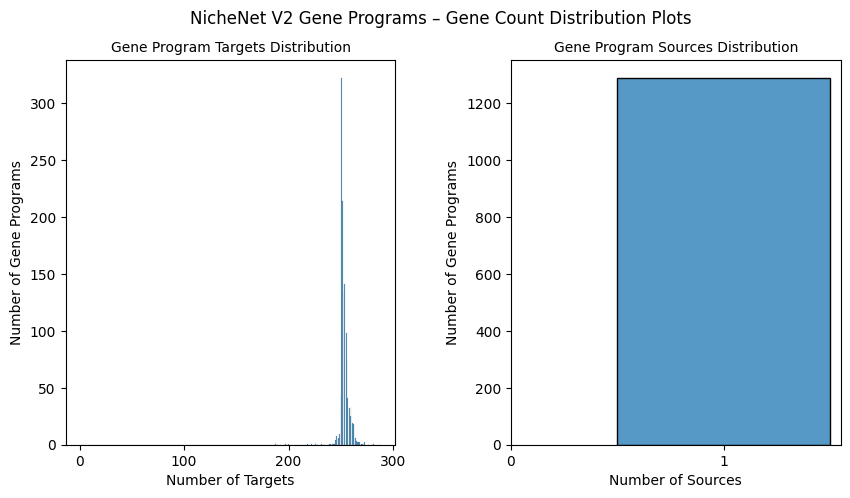

In [10]:
# Retrieve NicheNet GPs (source: ligand gene; target: target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species="mouse",
    version="v2",
    keep_target_genes_ratio=1.,
    max_n_target_genes_per_gp=250,
    load_from_disk=True,
    save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source genes from NicheNet GPs to keep
# those genes when filtering
nichenet_source_genes = get_unique_genes_from_gp_dict(
    gp_dict=nichenet_gp_dict,
    retrieved_gene_entities=["sources"])

In [11]:
# Display example NicheNet GPs
for i, (key, value) in enumerate(nichenet_gp_dict.items()):
    if i > 2:
        break
    print(key, value)

2300002M23Rik_ligand_receptor_target_gene_GP {'sources': ['2300002M23Rik'], 'targets': ['Ddr1', 'Adm', 'Agt', 'Angptl4', 'Ankrd1', 'App', 'Ar', 'Ass1', 'Atf3', 'Bax', 'Bcl2', 'Bcl2l1', 'Bcl2l11', 'Bcl3', 'Bcl6', 'Bdnf', 'Bhlhe40', 'Bin1', 'Birc3', 'Birc5', 'Bmp4', 'Bnip3l', 'Bnip3l-ps', 'Brca1', 'Btg2', 'Cav1', 'Cbx5', 'Ccl12', 'Ccl20', 'Ccl5', 'Ccn1', 'Ccn2', 'Ccna2', 'Ccnb1', 'Ccnb1-ps', 'Ccnd1', 'Ccnd2', 'Cd5l', 'Cdc6', 'Cdca7', 'Cdh1', 'Cdk1', 'Cdk4', 'Cdk6', 'Cdkn1a', 'Cdkn1b', 'Cdkn2a', 'Cdkn2c', 'Cebpa', 'Cflar', 'Cited2', 'Csf2', 'Cxcr4', 'Cyp1a1', 'Cyp1b1', 'Cyp24a1', 'Cyp3a13', 'Ddit3', 'Ddit4', 'Dhrs3', 'Dkk1', 'Dtl', 'Dusp1', 'Dusp6', 'E2f1', 'E2f3', 'Edn1', 'Egfr', 'Egr1', 'Egr2', 'Enc1', 'Eno1', 'Eno1b', 'Epha2', 'Esr1', 'Etfb', 'Fas', 'Fasn', 'Fkbp5', 'Fn1', 'Fos', 'Fosl1', 'Foxo3', 'Fst', 'Gadd45a', 'Gadd45b', 'Gadd45g', 'Gapdh', 'Gapdh-ps15', 'Gata3', 'Gdf15', 'Gm10358', 'Gm3839', 'Gm40460', 'Gm4559', 'Gm45618', 'H2bc14', 'H3f3b', 'H4c12', 'H4c14', 'Hes1', 'Hmga1', 'Hm

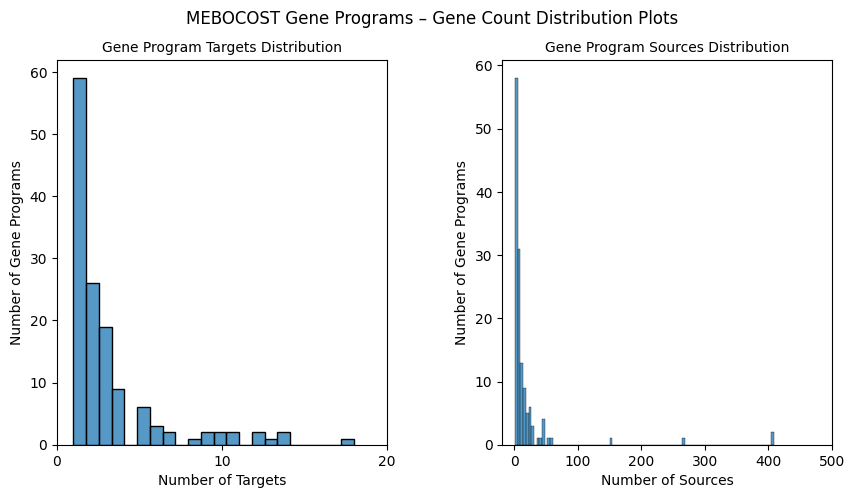

In [12]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species="mouse",
    plot_gp_gene_count_distributions=True)

# Retrieve unique source and target genes from MEBOCOST GPs to keep
# those genes when filtering
mebocost_genes = get_unique_genes_from_gp_dict(
    gp_dict=mebocost_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

In [13]:
# Display example MEBOCOST GPs
for i, (key, value) in enumerate(mebocost_gp_dict.items()):
    if i > 2:
        break
    print(key, value)

Deoxyuridine_metabolite_enzyme_sensor_GP {'sources': ['Cda', 'Pnp', 'Pnp2', 'Tk1', 'Tk2', 'Tymp'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme'], 'targets': ['Slc29a2'], 'targets_categories': ['sensor']}
Deoxycytidine_metabolite_enzyme_sensor_GP {'sources': ['Cda', 'Dck', 'Nt5c', 'Nt5c1a', 'Nt5c1b', 'Nt5c2', 'Nt5e', 'Nt5m'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme'], 'targets': ['Slc29a2'], 'targets_categories': ['sensor']}
3-Methoxytyramine_metabolite_enzyme_sensor_GP {'sources': ['Comt', 'Maoa', 'Maob'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme'], 'targets': ['Taar1'], 'targets_categories': ['sensor']}


In [14]:
# Add GPs into one combined dictionary
# for model training
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [15]:
# Filter and combine GPs to avoid overlaps
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 2324.
Number of gene programs after filtering and combining: 1818.


### 2.2 Load Data & Compute Spatial Neighbor Graph

- NicheCompass expects a precomputed spatial adjacency matrix stored in 'adata.obsp[adj_key]'.
- The user can customize the spatial neighbor graph construction based on the dataset, application, and hypothesis of interest.
- In the oneshot sample integration setting, we will compute a separate spatial adjacency matrix for each sample and combine them as disconnected components.

In [16]:
adata_batch_list = []

for batch in batches:
    print(f"Processing batch {batch}...")
    print("Loading data...")
    adata_batch = sc.read_h5ad(
        f"{so_data_folder_path}/{dataset}_{batch}.h5ad")

    print("Computing spatial neighborhood graph...\n")
    # Compute (separate) spatial neighborhood graphs
    sq.gr.spatial_neighbors(adata_batch,
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    
    # Make adjacency matrix symmetric
    adata_batch.obsp[adj_key] = (
        adata_batch.obsp[adj_key].maximum(
            adata_batch.obsp[adj_key].T))
    adata_batch_list.append(adata_batch)
adata = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
batch_connectivities = []
len_before_batch = 0
for i in range(len(adata_batch_list)):
    if i == 0: # first batch
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[0].shape[0],
            (adata.shape[0] -
            adata_batch_list[0].shape[0])))
        batch_connectivities.append(sp.hstack(
            (adata_batch_list[0].obsp[adj_key],
            after_batch_connectivities_extension)))
    elif i == (len(adata_batch_list) - 1): # last batch
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata.shape[0] -
            adata_batch_list[i].shape[0])))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key])))
    else: # middle batches
        before_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0], len_before_batch))
        after_batch_connectivities_extension = sp.csr_matrix(
            (adata_batch_list[i].shape[0],
            (adata.shape[0] -
            adata_batch_list[i].shape[0] -
            len_before_batch)))
        batch_connectivities.append(sp.hstack(
            (before_batch_connectivities_extension,
            adata_batch_list[i].obsp[adj_key],
            after_batch_connectivities_extension)))
    len_before_batch += adata_batch_list[i].shape[0]
adata.obsp[adj_key] = sp.vstack(batch_connectivities)

Processing batch batch1...
Loading data...
Computing spatial neighborhood graph...

Processing batch batch2...
Loading data...
Computing spatial neighborhood graph...

Processing batch batch3...
Loading data...
Computing spatial neighborhood graph...



### 2.3 Filter Genes

In [17]:
if filter_genes:
    print("Filtering genes...")
    # Filter genes and only keep ligand, receptor, metabolitye enzyme, 
    # metabolite sensor and the 'n_hvg' highly variable genes (potential target
    # genes of nichenet)
    gp_dict_genes = get_unique_genes_from_gp_dict(
        gp_dict=combined_new_gp_dict,
            retrieved_gene_entities=["sources", "targets"])
    print(f"Starting with {len(adata.var_names)} genes.")
    sc.pp.filter_genes(adata,
                       min_cells=0)
    print(f"Keeping {len(adata.var_names)} genes after filtering genes with "
          "expression in 0 cells.")

    sc.pp.highly_variable_genes(
        adata,
        layer=counts_key,
        n_top_genes=n_hvg,
        flavor="seurat_v3",
        batch_key=condition_key,
        subset=False)

    # Get gene program relevant genes
    gp_relevant_genes = list(set(omnipath_genes + 
                                 nichenet_source_genes + 
                                 mebocost_genes))
    
    adata.var["gp_relevant"] = (
        adata.var.index.str.upper().isin(gp_relevant_genes))
    adata.var["keep_gene"] = (adata.var["gp_relevant"] | 
                              adata.var["highly_variable"])
    adata = adata[:, adata.var["keep_gene"] == True]
    print(f"Keeping {len(adata.var_names)} highly variable or gene program "
          "relevant genes.")
    adata = (adata[:, adata.var_names[adata.var_names.str.upper().isin(
                [gene.upper() for gene in gp_dict_genes])].sort_values()])
    print(f"Keeping {len(adata.var_names)} genes after filtering genes not in "
          "gp dict.")

Filtering genes...
Starting with 1022 genes.
Keeping 1022 genes after filtering genes with expression in 0 cells.
Keeping 1022 highly variable or gene program relevant genes.
Keeping 883 genes after filtering genes not in gp dict.


### 2.4 Add GP Mask to Data

In [18]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

### 2.5 Explore Data

Summary of batch batch1:
Number of nodes (observations): 91246
Number of node features (genes): 883


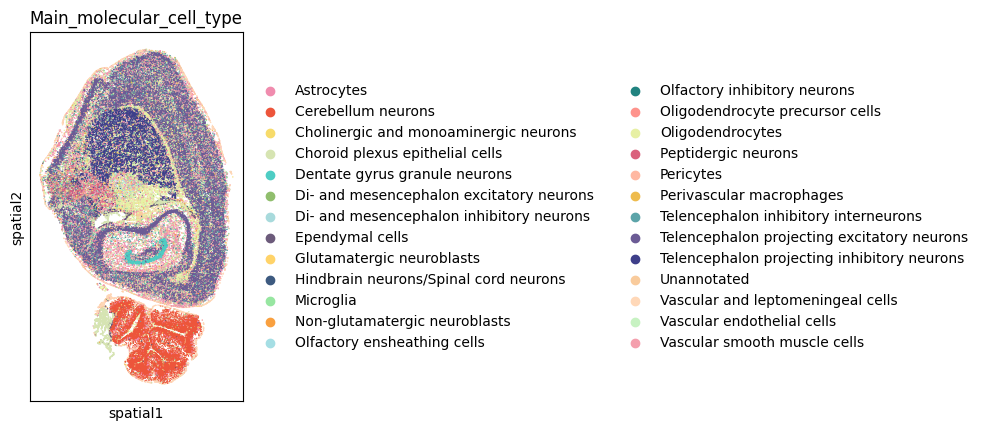

Summary of batch batch2:
Number of nodes (observations): 123836
Number of node features (genes): 883


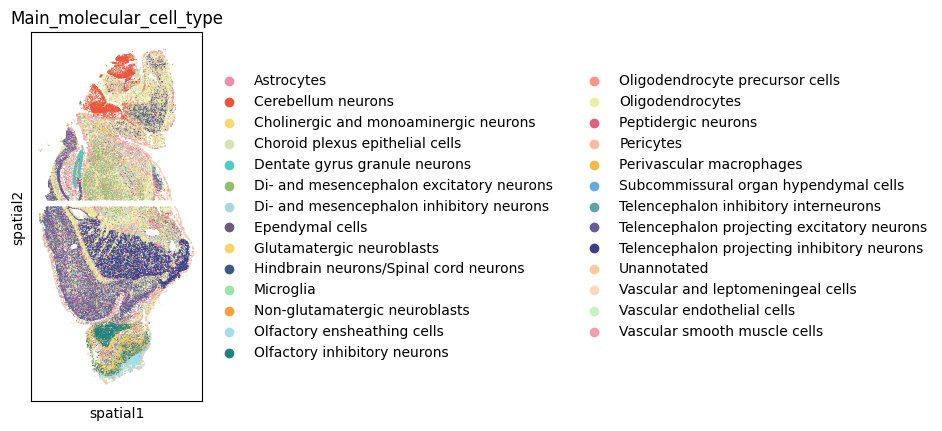

Summary of batch batch3:
Number of nodes (observations): 207591
Number of node features (genes): 883


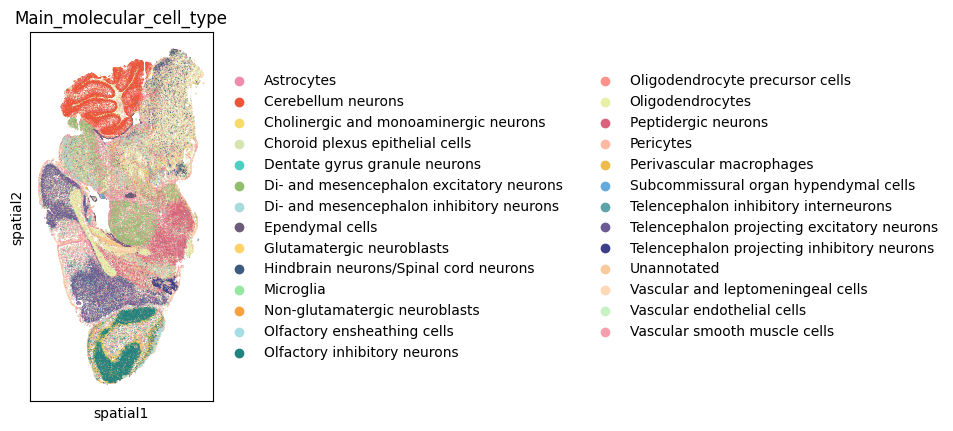

In [19]:
for batch_idx in range(1, len(batches) + 1):
    adata_batch = adata[adata.obs[condition_key] == f"sagittal{batch_idx}"]
    
    print(f"Summary of batch batch{batch_idx}:")
    print(f"Number of nodes (observations): {adata_batch.layers[counts_key].shape[0]}")
    print(f"Number of node features (genes): {adata_batch.layers[counts_key].shape[1]}")

    # Visualize cell-level annotated data in physical space
    sc.pl.spatial(adata_batch,
                  color=cell_type_key,
                  palette=cell_type_colors,
                  spot_size=spot_size)        

## 3. Model Training

### 3.1 Initialize, Train & Save Model

In [20]:
model.adata.obs

NameError: name 'model' is not defined

In [23]:
cat_covariates_keys = ["Main_molecular_tissue_region", "Sub_molecular_cell_type"]

In [29]:
adata_sample = adata[:5000, :]
n_epochs = 1

In [46]:
# Initialize model
model = NicheCompass(adata_sample,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     condition_key=condition_key,
                     cond_embed_injection=cond_embed_injection,
                     n_cond_embed=n_cond_embed,
                     cat_covariates_keys=cat_covariates_keys,
                     nums_cat_covariates_embed=[3, 3],
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     latent_key=latent_key,
                     active_gp_thresh_ratio=active_gp_thresh_ratio,
                     node_label_method=node_label_method)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.05
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder']
ENCODER -> n_input: 883, n_cond_embed_input: 3, n_cat_covariates_embed_input: 6, n_layers: 1, n_hidden: 883, n_latent: 1423, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 0, n_cond_embed_output: 1423, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 1423, n_cond_embed_input: 3, n_cat_covariates_embed_input: 6, n_addon_input: 0, n_output: 1766
ONE HOP ATTENTION NODE LABEL AGGREGATOR -> n_input: 883, n_heads: 4


In [45]:
del(model)
import gc
gc.collect()
import torch
torch.cuda.empty_cache()

In [47]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            n_epochs_no_cond_contrastive=n_epochs_no_cond_contrastive,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_cond_contrastive=lambda_cond_contrastive,
            contrastive_logits_pos_ratio=contrastive_logits_pos_ratio,
            contrastive_logits_neg_ratio=contrastive_logits_neg_ratio,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            node_batch_size=12,
            use_cuda_if_available=use_cuda_if_available,
            verbose=True)


--- INITIALIZING TRAINER ---
Number of training nodes: 4500
Number of validation nodes: 500
Number of training edges: 29739
Number of validation edges: 3304
Edge batch size: 1024
Node batch size: 12

--- MODEL TRAINING ---
Epoch 1/1 |████████████████████| 100.0% val_auroc_score: 0.7745; val_auprc_score: 0.7905; val_best_acc_score: 0.6866; val_best_f1_score: 0.7250; train_kl_reg_loss: 902.1668; train_edge_recon_loss: 341653.2177; train_cond_contrastive_loss: nan; train_gene_expr_recon_loss: 189522.8932; train_masked_gp_l1_reg_loss: 0.0000; train_group_lasso_reg_loss: 0.0000; train_global_loss: nan; train_optim_loss: 532078.2802; val_kl_reg_loss: 2766.3162; val_edge_recon_loss: 339145.2656; val_cond_contrastive_loss: nan; val_gene_expr_recon_loss: 165908.4375; val_masked_gp_l1_reg_loss: 0.0000; val_group_lasso_reg_loss: 0.0000; val_global_loss: nan; val_optim_loss: nan

Model training finished after 0 min 2 sec.

--- MODEL EVALUATION ---
Val AUROC score: 0.7781
Val AUPRC score: 0.7899
V

In [ ]:
use_cuda_if_available

In [52]:
model.model.device()

AttributeError: 'VGPGAE' object has no attribute 'device'

In [ ]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [48]:
# Save trained model
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

## 4. Analysis

In [52]:
load_timestamp = "22062023_100003"

figure_folder_path = f"{artifacts_folder_path}/oneshot_sample_integration/{load_timestamp}/figures"
model_folder_path = f"{artifacts_folder_path}/oneshot_sample_integration/{load_timestamp}/model"

os.makedirs(figure_folder_path, exist_ok=True)

In [53]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="adata.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.05
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder']
ENCODER -> n_input: 883, n_cond_embed_input: 3, n_cat_covariates_embed_input: 6, n_layers: 1, n_hidden: 883, n_latent: 1423, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 0, n_cond_embed_output: 1423, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 1423, n_cond_embed_input: 3, n_cat_covariates_embed_input: 6, n_addon_input: 0, n_output: 1766
ONE HOP ATTENTION NODE LABEL AGGREGATOR -> n_input: 883, n_heads: 4


### 4.1 Visualize NicheCompass Embeddings

First, we will check how well the NicheCompass embeddings are integrated across different batches.

In [ ]:
# Plot UMAP with batch annotations
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "batch_annotations_latent_space.svg"

fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 groups=groups,
                 return_fig=True)
fig.set_size_inches(12, 8)
plt.title(f"NicheCompass Embeddings Batch Annotations",
          size=20,
          pad=15)

if save_fig:
    fig.savefig(file_path,
                bbox_inches="tight")
else:
    fig.show()

Next, we will look at the preservation of cell type annotations in the embedding space. Note that the goal of NicheCompass is not a perfect separation of cell types but rather to identify spatial cellular niches. Nevertheless, it can be useful to look at the cell type annotations if available.

In [ ]:
# Plot UMAP with cell type annotations
groups = None
save_fig = True
file_path = f"{figure_folder_path}/" \
            "cell_type_annotations_latent_space.svg"

fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 palette=cell_type_colors,
                 groups=groups,
                 return_fig=True)
fig.set_size_inches(12, 8)
plt.title(f"NicheCompass Embeddings Cell Type Annotations",
          size=20,
          pad=15)

if save_fig:
    fig.savefig(file_path,
                bbox_inches="tight")
else:
    fig.show()

### 4.2 Identify Niches

We compute Leiden clustering based on the NicheCompass embeddings to identify spatial cellular niches.

In [ ]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [ ]:
# Create plot of cell type annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["0"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "latent_clusters_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Latent Clusters " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           title=f"Latent Clusters in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[latent_cluster_key],
                  groups=groups,
                  spot_size=spot_size,
                  title=f"Latent Clusters in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.3 Analyze Niches

Now we will analyze the identified spatial cellular niches.

#### 4.3.1 Niche Composition

We can analyze the niche composition in terms of cell type labels.

In [ ]:
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition.svg"

df_counts = (model.adata.obs.groupby([latent_cluster_key, cell_type_key])
             .size().unstack())
df_counts.plot(kind="bar", stacked=True, figsize=(10,10))
legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("Cell Type Annotations", prop={'size': 10})
plt.title("Cell Type Composition of Niches")
plt.xlabel("Niche")
plt.ylabel("Cell Type Counts")
if save_fig:
    plt.savefig(file_path,
                bbox_extra_artists=(legend,),
                bbox_inches="tight")

#### 4.3.2 Cell Type Neighbor Importances

Now we will investigate neighbor importances in terms of cell type labels of different niches.

In [ ]:
# Retrieve node neighbor importances 
# (aggregation weights of the node label aggregator)
model.adata.obsp[agg_weights_key] = model.get_neighbor_importances()

In [ ]:
# Get cell type neighbor importances for each niche / latent cluster
niche_neighbor_importances_df = aggregate_obsp_matrix_per_cell_type(
    adata=model.adata,
    obsp_key=agg_weights_key,
    cell_type_key=cell_type_key,
    group_key=latent_cluster_key,
    agg_rows=True)

In [ ]:
display(niche_neighbor_importances_df)

In [ ]:
# Generate chord plots showing cell type neighbor importances
# for each niche / latent cluster
groups = ["0", "1", "2", "3", "4", "5"] # "all"
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_neighbor_importances.png"

create_cell_type_chord_plot_from_df(
        adata=model.adata,
        df=niche_neighbor_importances_df,
        link_threshold=0.01,
        cell_type_key=cell_type_key,
        group_key=latent_cluster_key,
        groups=groups,
        plot_label="Niche",
        save_fig=save_fig,
        file_path=file_path)

### 4.4 Perform Differential Gene Program Testing

Now we can test which communication gene programs are differentially expressed in a niche. To this end, we will perform differential gene program testing of a selected niche, e.g. latent cluster / niche "0" (```selected_cats = ["0"]```) vs all other latent clusters / niches (```comparison_cats = "rest"```). However, differential gene program testing can also be performed in the following ways:
- Set ```selected_cats = None``` to perform differential gene program testing across all niches, as opposed to just for one specific niche.
- Set ```comparison_cats = ["2", "3"]``` to perform differential gene program testing against latent clusters / niches "2" and "3" as opposed to against all other latent clusters / niches.

We choose a log bayes factor threshold of 2.3 to determine strongly enriched gene programs. Alternatively, the threshold could be set to a more restrictive value of 4.6 to only allow decisively enriched gene programs to be identified (see https://en.wikipedia.org/wiki/Bayes_factor).

In [ ]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

In [ ]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

In [ ]:
# Set parameters for differential gp testing
selected_cats = ["0"]
comparison_cats = "rest"
title = f"NicheCompass Latent Cluster Strongly Enriched Gene Programs"
log_bayes_factor_thresh = 2.3 # 4.6 decisive threshold (https://en.wikipedia.org/wiki/Bayes_factor)
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_latent_clusters_enriched_gps_dotplot.svg"

In [ ]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [ ]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

In [ ]:
# Create dotplot of results
fig = sc.pl.dotplot(model.adata,
                    enriched_gps,
                    groupby=latent_cluster_key,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[latent_cluster_key].nunique() / 2,
                             len(enriched_gps) / 2))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "latent_clusters_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_weights_sign_corrected",
                   "gp_target_genes_weights_sign_corrected",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

### 4.5 Analyze Enriched Gene Programs

Now we will have a look at the gene program scores as well as the (log normalized) count distributions of
the most important omics features of the differentially expressed gene programs.

In [ ]:
plot_label = "log_bayes_factor_2.3_cluster_0_vs_rest"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gps=10,
    feature_spaces=["sagittal1"], # ["sagittal2", "sagittal3", "latent"]
    n_top_genes_per_gp=3,
    log_norm_omics_features=True,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)